In [1]:
import pandas as pd
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint

In [7]:
# Load your dataset
url = 'C:/Users/grim/Desktop/stockpredict/LICN.csv'
df = pd.read_csv(url)
df = df.map(lambda x: str(x).replace(',', ''))

In [8]:
# Convert columns to numeric, handling errors
numeric_columns = ['Open', 'High', 'Low', 'Ltp', 'Qty', 'Turnover'] #'Inflation Rate','% Change'
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Consider multiple features
features = numeric_columns
df1 = df[features]

# Calculate IQR for each feature
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

# Define a threshold for outlier detection (you can adjust this threshold)
threshold = 1.5

# Identify outliers based on the IQR
outliers = ((df1 < (Q1 - threshold * IQR)) | (df1 > (Q3 + threshold * IQR))).any(axis=1)

# Remove rows with outliers
df1_no_outliers = df1[~outliers]
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_normalized = scaler.fit_transform(df1)

In [9]:
# Split the data into training and test sets
training_size = int(len(df_normalized) * 0.8)
test_size = len(df_normalized) - training_size
train_data, test_data = df_normalized[0:training_size, :], df_normalized[training_size:len(df_normalized), :]

# Function to create dataset with multiple features
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, :])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the input data
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], len(features))
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], len(features))

Epoch 1/100
33/33 [==============================] - 5s 65ms/step - loss: 0.0277 - val_loss: 0.0076
Epoch 2/100
33/33 [==============================] - 1s 34ms/step - loss: 0.0042 - val_loss: 0.0054
Epoch 3/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 4/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 5/100
33/33 [==============================] - 1s 37ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 6/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 7/100
33/33 [==============================] - 1s 38ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 8/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 9/100
33/33 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 0.0042
Epoch 10/100
33/33 [==============================] - 1s 35ms/step - loss: 0.0023 - val_loss: 0.0040

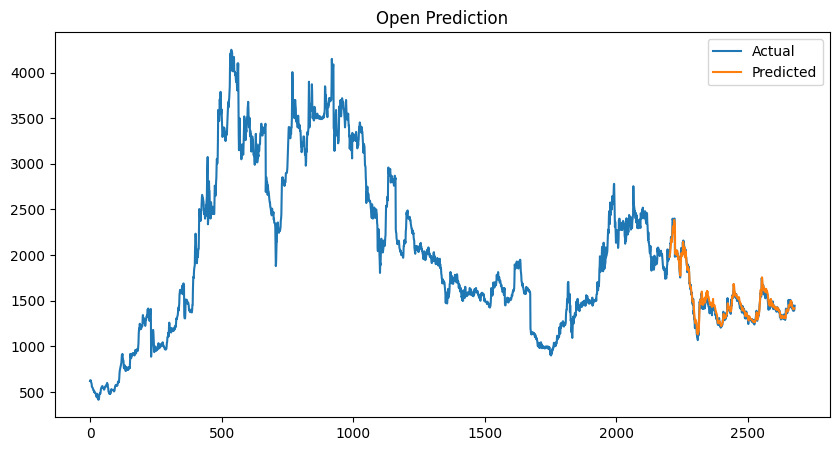

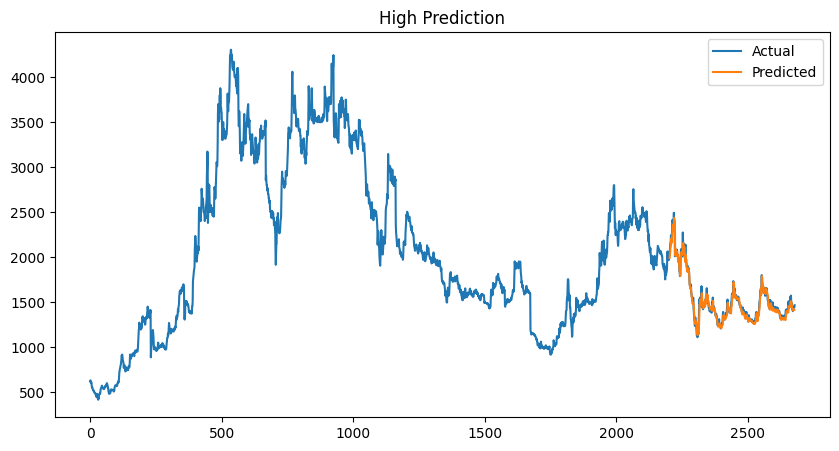

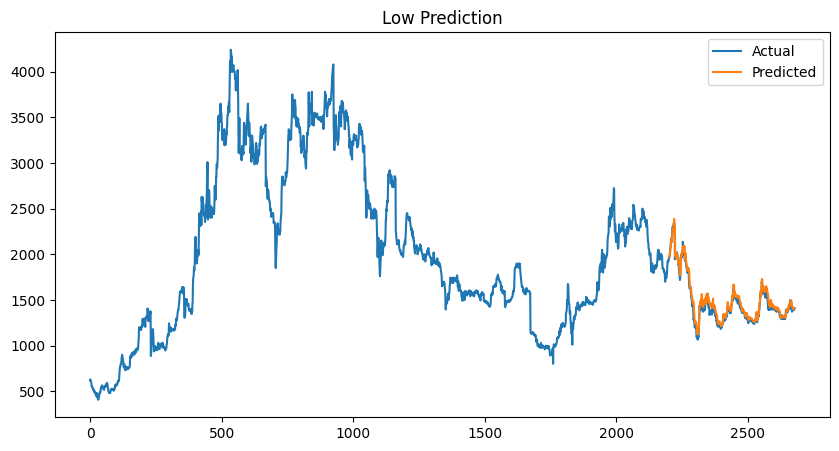

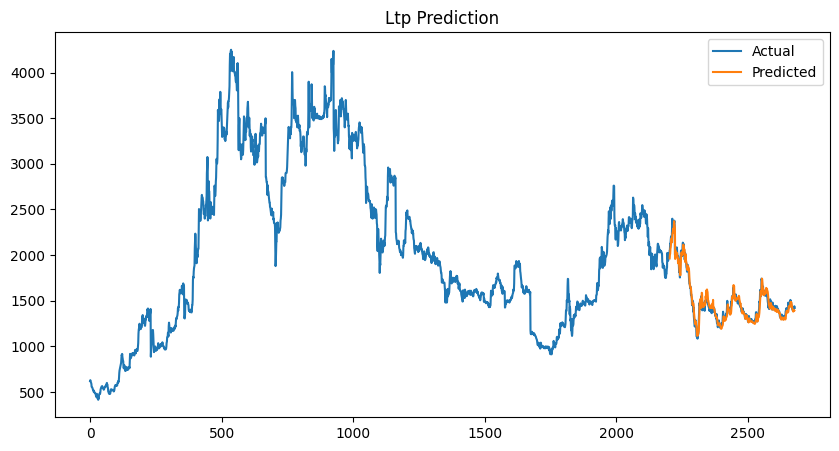

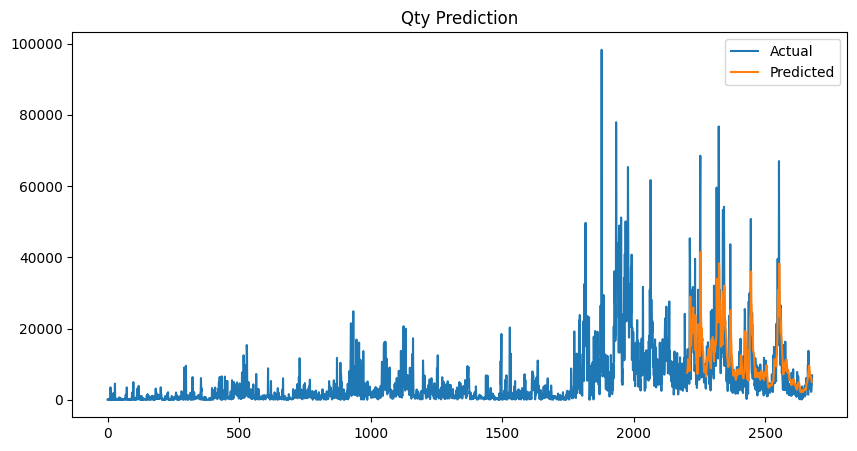

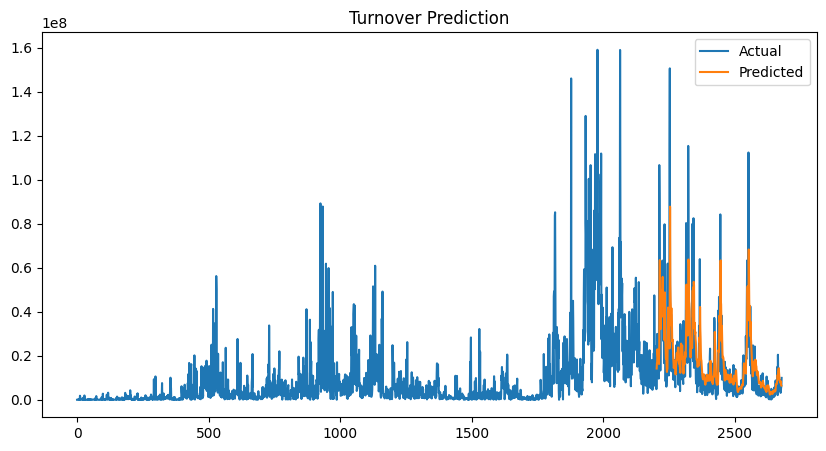

In [10]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, len(features))))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(len(features), activation='linear'))  # Adjust the number of neurons in the Dense layer based on the number of features
model.compile(loss='mean_squared_error', optimizer='adam')

# Set up model checkpoint to save weights at each epoch
checkpoint_path = "/content/drive/MyDrive/content/weightsnlic/weights_epoch_{epoch:02d}.h5"
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=True, period=1)


# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1, callbacks=[checkpoint])

# Make predictions
test_predict = model.predict(X_test)

# Inverse transform the predictions
test_predict = scaler.inverse_transform(test_predict)

# Plot the results
look_back = 60

# Plot the data
import matplotlib.pyplot as plt

for feature_idx in range(len(features)):
    testPredictPlot = np.empty_like(df_normalized)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(y_train) + (look_back * 2) + 1:len(df_normalized) - 1, feature_idx] = test_predict[:, feature_idx]

    plt.figure(figsize=(10, 5))
    plt.plot(scaler.inverse_transform(df_normalized)[:, feature_idx], label='Actual')
    plt.plot(testPredictPlot[:, feature_idx], label='Predicted')
    plt.title(f'{features[feature_idx]} Prediction')
    plt.legend()
    plt.show()




In [11]:
#MAPE Error

from sklearn.metrics import mean_squared_error
from math import sqrt

# Inverse transform the true values for the test set
y_test_actual = scaler.inverse_transform(y_test)

# Inverse transform the predicted values for the test set
y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)


# Calculate MAPE
mape = np.mean(np.abs((y_test_actual - y_test_pred) / y_test_actual)) * 100
print(f'MAPE: {mape}%')



15/15 [==============================] - 0s 10ms/step
MAPE: 37.250748801433126%


In [ ]:
#predictions


# Make predictions for the next day
last_day_data = df_normalized[-time_step:, :]
last_day_data = last_day_data.reshape(1, time_step, len(features))
predicted_values = model.predict(last_day_data)

# Inverse transform the predicted values
predicted_values = scaler.inverse_transform(predicted_values)

# Print the predicted values
predicted_df = pd.DataFrame(predicted_values, columns=features)
print("Predicted Values for the Next Day:")
print(predicted_df)